In [25]:
# original tutorial is here:
# https://docs.pymc.io/notebooks/multilevel_modeling.html

# Additional Blog Posts
# https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
# https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

# Michael Betancourt in his StanCon 2017 talk
# https://www.youtube.com/watch?v=DJ0c7Bm5Djk&feature=youtu.be&t=4h40m9s

%matplotlib inline
import numpy as np
import pandas as pd
from pymc3 import __version__
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(__version__))

from pymc3 import get_data
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
#note installing graphviz is
# brew install graphviz (mac)
# sudo apt-get install graphviz (ubuntu)
#  pip install graphviz
import arviz as az

%matplotlib inline

Running on PyMC3 v3.7


In [8]:
# Import radon data
srrs2 = pd.read_csv(get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,5995,MN,MN,27,55363,5,1,0,4,Y,...,1730,122687,122887,6.4,4.5,1146.499190,0,0,171,WRIGHT
5995,5996,MN,MN,27,55376,5,1,0,7,Y,...,700,121787,121987,4.5,8.3,1105.956867,0,0,171,WRIGHT
5996,5997,MN,MN,27,55376,5,1,0,4,Y,...,1045,12888,13088,5.0,5.2,1214.922779,0,0,171,WRIGHT
5997,5998,MN,MN,27,56297,5,1,0,4,Y,...,940,122887,123087,3.7,9.6,1177.377355,0,0,173,YELLOW MEDICINE


In [9]:
# obtain the county-level predictor, uranium, by combining two variables.
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips
cty_mn

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1326,27,1,MN,AITKIN,-93.415,46.608,0.502054,27001
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009
...,...,...,...,...,...,...,...,...
1410,27,165,MN,WATONWAN,-94.614,43.978,1.201100,27165
1411,27,167,MN,WILKIN,-96.468,46.357,1.266220,27167
1412,27,169,MN,WINONA,-91.780,43.987,1.589170,27169
1413,27,171,MN,WRIGHT,-93.963,45.174,0.913909,27171


In [10]:
# Use the merge method to combine home- and county-level information in a single DataFrame.
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)
srrs_mn

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,5995,MN,MN,27,55363,5,1,0,4,Y,...,122887,6.4,4.5,1146.499190,0,0,171,WRIGHT,27171,0.913909
923,5996,MN,MN,27,55376,5,1,0,7,Y,...,121987,4.5,8.3,1105.956867,0,0,171,WRIGHT,27171,0.913909
924,5997,MN,MN,27,55376,5,1,0,4,Y,...,13088,5.0,5.2,1214.922779,0,0,171,WRIGHT,27171,0.913909
925,5998,MN,MN,27,56297,5,1,0,4,Y,...,123087,3.7,9.6,1177.377355,0,0,173,YELLOW MEDICINE,27173,1.426590


In [12]:
# We also need a lookup table (dict) for each unique county, for indexing.
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
print(county_lookup)

{'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 'RICE': 63, 'ROCK': 64, 'ROSEAU': 65, 'SCOTT': 66, 

In [13]:
# create local copies of variables.
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

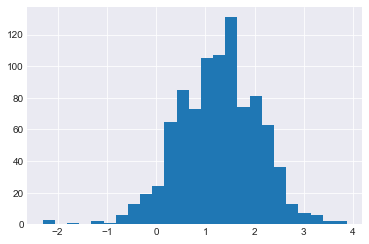

In [14]:
# Distribution of radon levels in MN (log scale):
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25);

## Conventional approaches¶
The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

**Complete pooling:**

Treat all counties the same, and estimate a single radon level:
$$ y_i = \alpha + \beta x_i + \epsilon_i $$

**No pooling:**

Model radon in each county independently:
$$ y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i $$
where j = 0, ..., 84

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

Here are the point estimates of the slope and intercept for the complete pooling model:

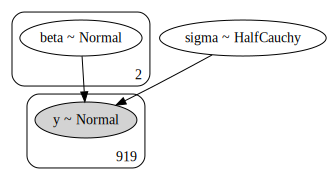

In [21]:
floor = srrs_mn.floor.values
log_radon = srrs_mn.log_radon.values

with Model() as pooled_model:

    beta = Normal('beta', 0, sigma=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = Normal('y', theta, sigma=sigma, observed=log_radon)
model_to_graphviz(pooled_model)

In [22]:

with pooled_model:
    pooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4024.14draws/s]


/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1357b3940>,
      dtype=object)

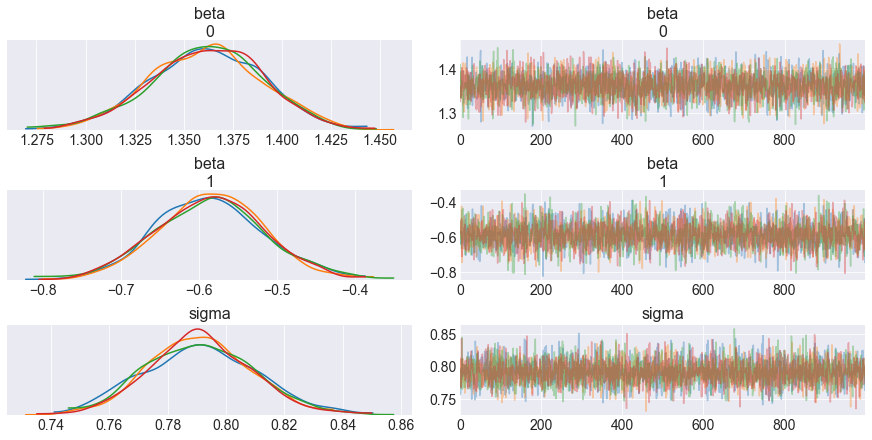

In [27]:
az.plot_trace(pooled_trace)

In [33]:

b0, m0 = pooled_trace['beta'].mean(axis=0)
print(b0)
print(m0)

1.361643851924986
-0.5849831951961451


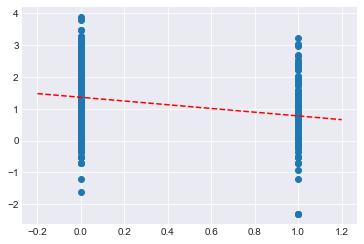

In [34]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--');

Estimates of county radon levels for the unpooled model: